# SRGAN

## Goal of this project
1. Understand Super Resolution and the basic concepts needed to perform the process.
2. Understand and utilize the two representative structures (SRCNN, SRGAN) used in Super Resolution.
3. Create a high-resolution image using SRGAN.
4. Compare and analyze various resolutions, the original, SRGAN-generated version, and interpolation-generated. (correlating the image characteristics with the super resolution method.)
5. Convert a low-resolution gif video to a high-resolution video.

## Model
I used pre-trained SRGAN model provided by Aiffel.

## Dataset
I downloaded 3 random images that I want to improve resolution. 1. Jeong Sewoon low-resolution jpeg, 2. Jeong Sewoon high-resolution jpeg, and 3. Jeong Sewoon low-resolution gif file.

## Table of Contents
 1. Convert Image from High Resolution to Row Resolution
 2. Convert Image from Low Resolution to High Resolution
 3. Create high-resolution .gif using SRGAN
 3. Conclusion

Load the pre-trained SRGAN model

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [3]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

# 1. Convert Image from High Resolution to Row Resolution
1. Search for an image with a (moderately) high resolution, select one, save and load it.
2. Apply bicubic interpolation to the loaded image to reduce the number of horizontal and vertical pixels by 1/4. Let's try cv2.resize().
3. Generates a high-resolution image using SRGAN as input with a reduced low-resolution image. It's easy with the apply_srgan function we used earlier.
4. Apply bicubic interpolation to the image in 2. to quadruple the number of horizontal and vertical pixels again. Similarly, let's use cv2.resize().
5. Visualize the three images side-by-side (Bicubic results in 4., SRGAN results in 3., and original high-resolution images in 1.). Please indicate the result for which method in the title of each image. It's not difficult if you refer to the code we used for the previous visualization.
6. Explain the results when the selected image was super-resolved with a model trained on the DIV2K dataset, and why these results were output. (there is no right answer)

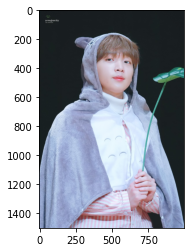

In [10]:
img_original = cv2.cvtColor(cv2.imread('./sewoon_high_res.jpeg'),cv2.COLOR_BGR2RGB)
plt.imshow(img_original)

In [20]:
img_lr = cv2.resize(
    img_original,
    dsize = (img_original.shape[1]//4,img_original.shape[0]//4),
    interpolation = cv2.INTER_CUBIC
)

Enlarge the image back to bicubic

In [18]:
img_hr = cv2.resize(
    img_lr, 
    dsize=(img_original.shape[1], img_original.shape[0]),
    interpolation=cv2.INTER_CUBIC 
)

In [19]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_hr = apply_srgan(img_lr)

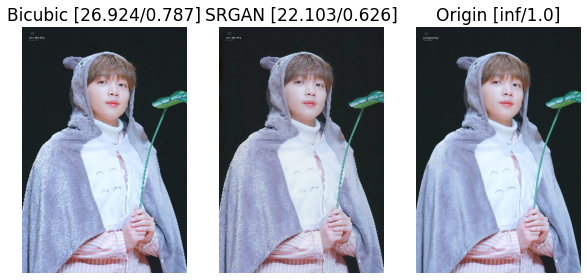

In [28]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

images = [img_hr, srgan_hr, img_original]
titles = ["Bicubic", "SRGAN", "Origin"]

psnr = [round(peak_signal_noise_ratio(img_original, i), 3) for i in images]
ssim = [round(structural_similarity(img_original, i, multichannel=True), 3) for i in images]

plt.figure(figsize=(10,50))
for i in range(3):
    plt.subplot(1,3,i+1) 
    plt.imshow(images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=17)
    plt.axis('off')

# 2. Convert Image from Low Resolution to High Resolution
1. Search for an image with a (moderately) low resolution, select one, save and load it.
2. Create a high-resolution image using SRGAN with the loaded image as input. It's easy with the apply_srgan function we used earlier.
3. Apply bicubic interpolation to the image loaded in 1. to quadruple the number of horizontal and vertical pixels again. Let's try cv2.resize().
4. Visualize the two images side-by-side (the result of Bicubic in 3., and SRGAN in 2.). 5. Please indicate the result for which method in the title of each image. It's not difficult if you refer to the code we used for the previous visualization.
6. Explain the results when the selected image was super-resolved with a model trained on the DIV2K dataset, and why these results were output. (there is no right answer)

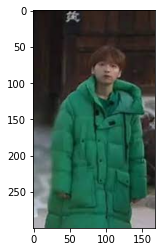

In [29]:
img_original_low = cv2.cvtColor(cv2.imread('./sewoon_low_res.jpeg'),cv2.COLOR_BGR2RGB)
plt.imshow(img_original_low)

In [30]:
srgan_hr_low = apply_srgan(img_original_low)

In [31]:
img_hr_low = cv2.resize(
    img_original_low,
    dsize = (img_original_low.shape[1]*4,img_original_low.shape[0]*4),
    interpolation = cv2.INTER_CUBIC
)

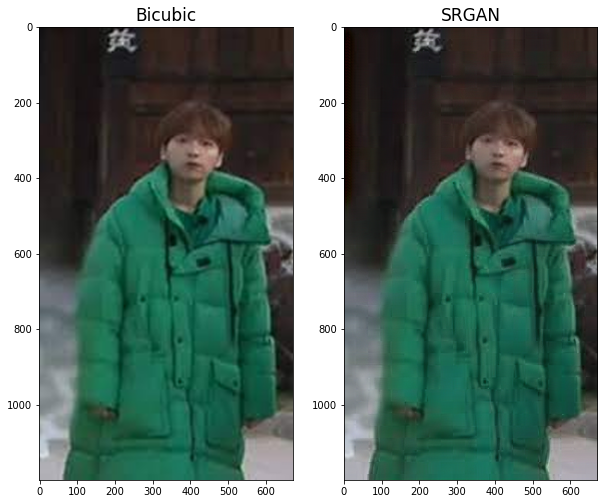

In [33]:
images_low = [img_hr_low, srgan_hr_low]
titles_low = ["Bicubic", "SRGAN"]

plt.figure(figsize=(10,30))
for i in range(2):
    plt.subplot(1,2,i+1) 
    plt.imshow(images_low[i])
    plt.title(titles_low[i], fontsize=17)

# 3. Create high-resolution .gif using SRGAN
We can also convert a low-resolution image into a high-resolution image using the already learned SRGAN.

The Super Resolution of a video is better to consider multiple frames of information in time sequence, but it takes a lot of time to train from scratch. Here, we will convert the high-resolution image frame by frame using the previously used SRGAN, apply it to all frames, and combine the frames to make a video.

In [35]:
gif = cv2.VideoCapture("./sewoon_low_res_gif.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("# of frame :", len(frames))
print("amount of frame :", (frames[0].shape))

# of frame : 69
amount of frame : (444, 480, 3)


## Apply Super Resolution per frame

Use Bicubic interpolation and SRGAN to quadruple each horizontal and vertical pixel count.    
Put each result after Super Resolution into a list called frames_sr.

In [37]:
frames_srg = []
for f in frames:
    frames_srg.append(apply_srgan(f))

In [39]:
imageio.mimsave("./hr_srg.gif", frames_srg)


In [ ]:
show_gif("./hr_srg.gif", width=350)

In [47]:
from IPython import display
display.Image(url="https://media.giphy.com/media/tc0FAr43kbnmK194g5/giphy.gif?cid=790b761193932379144723d71b9cb418d5dc421da20f13bf&rid=giphy.gif&ct=g")

# 4. Conclusion
## Result
1. High to Low resolution
- Interpolation score: bicubic interpolation score was higher (PSNR vs SSIM).   
- SRGAN's result seems to have more higher resolution, the image looks more clear.

2. Low to High resolution
- It's hard to differentiate between two images, but Bicubic looks slightly more clear.

3. Super Resolution for GIF
- The file size gets much larger.